In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.vgg19 import VGG19
import tensorflow_datasets as tfds

!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [3]:
img_size = 224
batch_size = 16
epochs = 40
learning_rate = 0.001
weight_decay = 0.0001
learning_rate = 1e-3

In [4]:
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (img_size, img_size))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

del raw_train
del raw_validation
del raw_test

In [6]:
train = train.unbatch().batch(batch_size,drop_remainder=True).repeat().shuffle(512)
validation_data = validation.unbatch().batch(batch_size,drop_remainder=True).repeat()

In [7]:
steps_per_epoch = metadata.splits["train"].num_examples / batch_size 
validation_steps = metadata.splits["validation"].num_examples / batch_size

In [8]:
!pip install efficientnet==1.1.0
from efficientnet import tfkeras as efficientnet

efficientnet_model = efficientnet.EfficientNetB4(
    weights='noisy-student',
    pooling='avg',
    include_top=False,
    input_shape=(img_size,img_size,3)
)

for layer in efficientnet_model.layers:
    layer.trainable = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
71678424/71678424 [==============================] - 0s 0us/step


In [9]:
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(102)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4 (Functional  (None, 1792)             17673816  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 4096)              7344128   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 102)               417894    
                                                        

In [10]:
def run_experiment(model):

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  hist = model.fit(
    x=train,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history
  
  model.load_weights(checkpoint_filepath)

  return hist

In [11]:
hist = run_experiment(model)

Epoch 1/50
63/63 [==============================] - 77s 256ms/step - loss: 3.6379 - accuracy: 0.2363 - val_loss: 3.2752 - val_accuracy: 0.2773
Epoch 2/50
63/63 [==============================] - 17s 271ms/step - loss: 2.1473 - accuracy: 0.4600 - val_loss: 2.3188 - val_accuracy: 0.4395
Epoch 3/50
63/63 [==============================] - 13s 210ms/step - loss: 1.6338 - accuracy: 0.5625 - val_loss: 1.7647 - val_accuracy: 0.5078
Epoch 4/50
63/63 [==============================] - 17s 266ms/step - loss: 1.6427 - accuracy: 0.5391 - val_loss: 1.4476 - val_accuracy: 0.5928
Epoch 5/50
63/63 [==============================] - 14s 215ms/step - loss: 1.2737 - accuracy: 0.6436 - val_loss: 1.1101 - val_accuracy: 0.6699
Epoch 6/50
63/63 [==============================] - 16s 248ms/step - loss: 1.2391 - accuracy: 0.6475 - val_loss: 1.3702 - val_accuracy: 0.5967
Epoch 7/50
63/63 [==============================] - 16s 250ms/step - loss: 1.2140 - accuracy: 0.6416 - val_loss: 1.2412 - val_accuracy: 0.6445

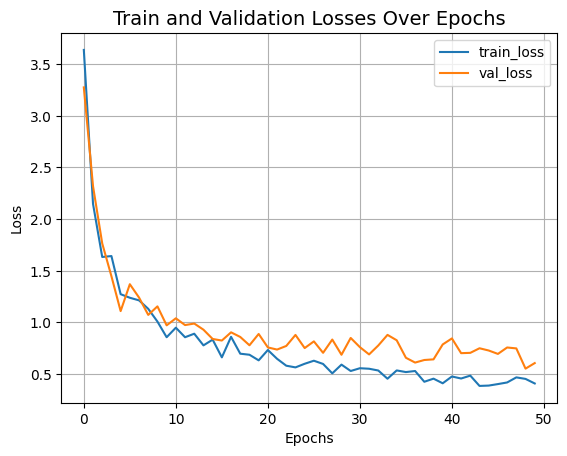

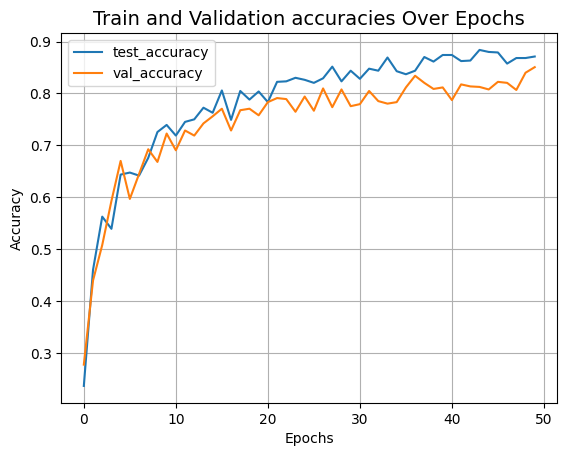

In [12]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
model.evaluate(validation)

32/32 [==============================] - 10s 182ms/step - loss: 0.6048 - accuracy: 0.8500


[0.6048049330711365, 0.8500000238418579]

In [14]:
model.evaluate(test)

32/32 [==============================] - 5s 157ms/step - loss: 0.7509 - accuracy: 0.8059


[0.7508687376976013, 0.8058823347091675]

In [15]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

32/32 [==============================] - 6s 134ms/step


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.8058823529411765


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obtendo as previsões do modelo para o conjunto de teste
y_pred = predicted_classes

# Obtendo os rótulos verdadeiros do conjunto de teste
y_true = true_classes

# Calculando o recall ponderado
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Calculando a precisão ponderada
weighted_precision = precision_score(y_true, y_pred, average='weighted')

# Calculando o F1-score ponderado
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')

# Imprimindo os resultados
print("Weighted Recall:", weighted_recall)
print("Weighted Precision:", weighted_precision)
print("Weighted F1-Score:", weighted_f1_score)

Weighted Recall: 0.8058823529411765
Weighted Precision: 0.8361607560000384
Weighted F1-Score: 0.8011520060860483
